In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, cross_validate

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score

In [3]:
TARGET_COL = "duration"
OTHERS = ["genre_top", "duration_minutes"]
TEST_SIZE = 0.2
N_SPLITS = 4

## Load merged dataset

In [4]:
df_train = pd.read_csv("../DataBase/processed/train_data.csv")
print(df_train.shape)

df_test = pd.read_csv("../DataBase/processed/test_data.csv")
print(df_test.shape)

(5493, 41)
(1374, 41)


## Data preprocessing

In [5]:
df_train = df_train[df_train[TARGET_COL].notna()].dropna().copy()
print(df_train.shape)

df_test = df_test[df_test[TARGET_COL].notna()].dropna().copy()
print(df_test.shape)

(5493, 41)
(1374, 41)


In [ ]:
X_train, X_test = df_train.drop(columns=[TARGET_COL] + OTHERS), df_test.drop(columns=[TARGET_COL] + OTHERS)
y_train, y_test = df_train[TARGET_COL], df_test[TARGET_COL]

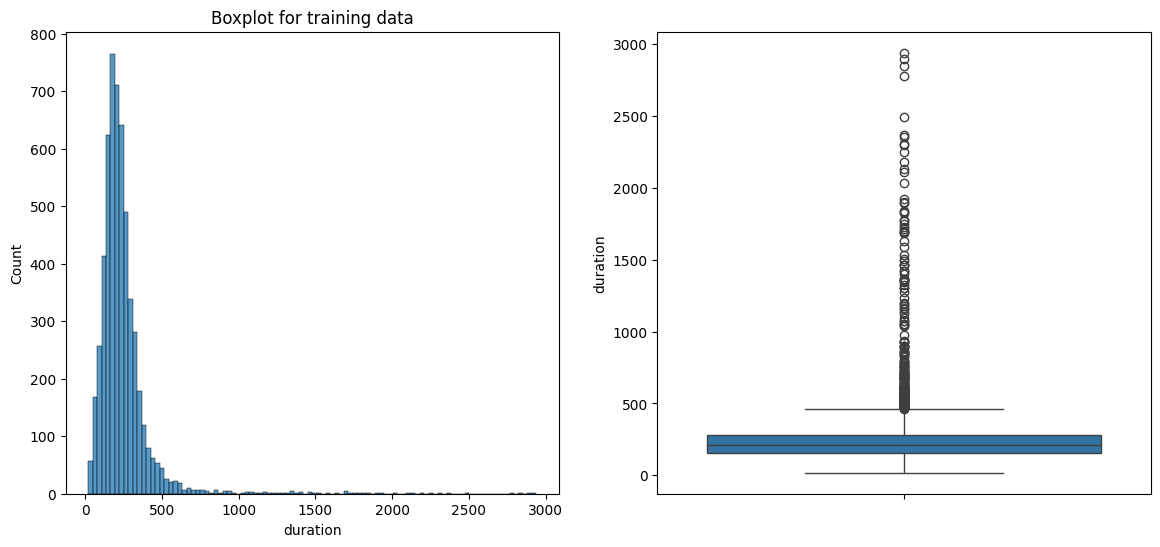

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(y_train, bins=100, ax=axes[0])
axes[0].set_title("Repartition for training data")
sns.boxplot(y_train, ax=axes[1])
axes[0].set_title("Boxplot for training data")
plt.show()

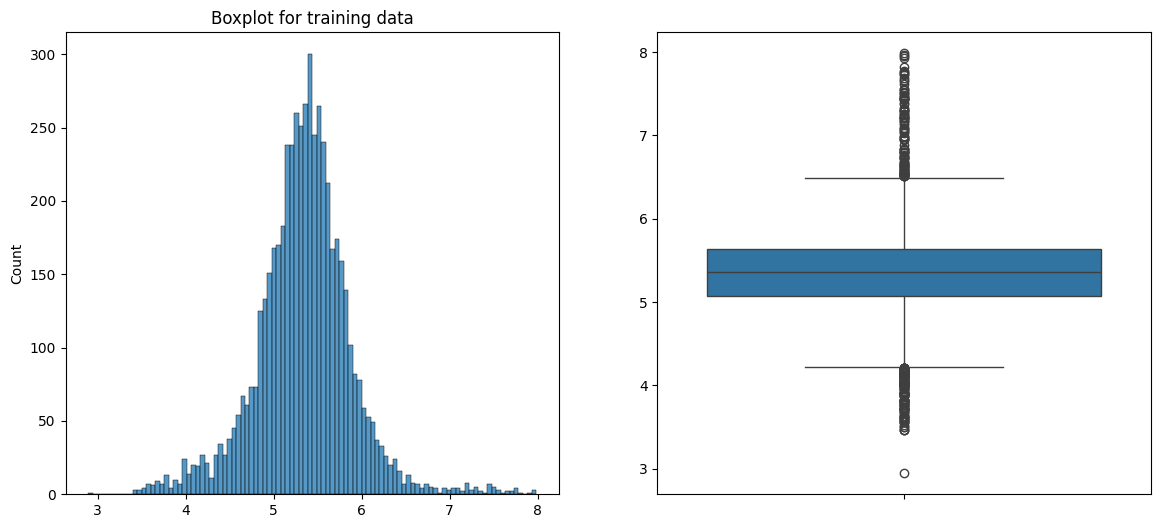

In [8]:
y_train_transformed = [np.log1p(value) for value in y_train]
y_test_transformed = [np.log1p(value) for value in y_test]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot([np.log(value) for value in y_train], bins=100, ax=axes[0])
axes[0].set_title("Repartition for training data")
sns.boxplot([np.log(value + 1) for value in y_train], ax=axes[1])
axes[0].set_title("Boxplot for training data")
plt.show()

## Model training

## With coarse_genre_top GroupKFold

In [9]:
group_kfold = KFold(N_SPLITS)

In [10]:
def inv_transform(value):
    return np.exp(value) - 1

### SVM

In [11]:
svm = SVR()

scoring = ["neg_root_mean_squared_error", "neg_mean_squared_error", "r2"]
scores = cross_validate(
	svm,
	X_train,
	y_train_transformed,
	cv=group_kfold,
	scoring=scoring
)

print(f"RMSE: {-np.mean(scores["test_neg_root_mean_squared_error"]):.4f} +- {np.std(scores["test_neg_root_mean_squared_error"]):.4f}")
print(f"MSE: {-np.mean(scores["test_neg_mean_squared_error"]):.4f} +- {np.std(scores["test_neg_mean_squared_error"]):.4f}")
print(f"r2: {-np.mean(scores["test_r2"]):.4f} +- {np.std(scores["test_r2"]):.4f}")

RMSE: 0.5343 +- 0.0057
MSE: 0.2855 +- 0.0061
r2: -0.0235 +- 0.0101


In [12]:
svm.fit(X_train, y_train_transformed)
predictions = svm.predict(X_test)
inv_predictions = [inv_transform(value) for value in predictions]
print("Metrics in transformed space:")
print(f"RMSE: {root_mean_squared_error(y_test_transformed, predictions):.4f}")
print(f"MSE:, {mean_squared_error(y_test_transformed, predictions):.4f}")
print(f"r2: {r2_score(y_test_transformed, predictions):.4f}")
print("----------------------")
print("Metrics in original space:")
print(f"RMSE: {root_mean_squared_error(y_test, inv_predictions):.4f}")
print(f"MSE:, {mean_squared_error(y_test, inv_predictions):.4f}")
print(f"r2: {r2_score(y_test, inv_predictions):.4f}")

Metrics in transformed space:
RMSE: 0.5309
MSE:, 0.2818
r2: 0.0155
----------------------
Metrics in original space:
RMSE: 210.1671
MSE:, 44170.2086
r2: -0.0184


### Random Forest

In [13]:
random_forest = RandomForestRegressor()

scoring = ["neg_root_mean_squared_error", "neg_mean_squared_error", "r2"]
scores = cross_validate(
	random_forest,
	X_train,
	y_train,
	cv=group_kfold,
	scoring=scoring
)

print(f"RMSE: {-np.mean(scores["test_neg_root_mean_squared_error"]):.4f} +- {np.std(scores["test_neg_root_mean_squared_error"]):.4f}")
print(f"MSE: {-np.mean(scores["test_neg_mean_squared_error"]):.4f} +- {np.std(scores["test_neg_mean_squared_error"]):.4f}")
print(f"r2: {-np.mean(scores["test_r2"]):.4f} +- {np.std(scores["test_r2"]):.4f}")

RMSE: 139.6638 +- 12.0893
MSE: 19652.1237 +- 3460.3500
r2: -0.5023 +- 0.0490


In [14]:
random_forest.fit(X_train, y_train_transformed)
predictions = svm.predict(X_test)
inv_predictions = [inv_transform(value) for value in predictions]
print("Metrics in transformed space:")
print(f"RMSE: {root_mean_squared_error(y_test_transformed, predictions):.4f}")
print(f"MSE:, {mean_squared_error(y_test_transformed, predictions):.4f}")
print(f"r2: {r2_score(y_test_transformed, predictions):.4f}")
print("----------------------")
print("Metrics in original space:")
print(f"RMSE: {root_mean_squared_error(y_test, inv_predictions):.4f}")
print(f"MSE:, {mean_squared_error(y_test, inv_predictions):.4f}")
print(f"r2: {r2_score(y_test, inv_predictions):.4f}")

Metrics in transformed space:
RMSE: 0.5598
MSE:, 0.3134
r2: 0.0276
----------------------
Metrics in original space:
RMSE: 218.2000
MSE:, 47611.2258
r2: -0.0108


### XGBoost

In [14]:
xgb = XGBRegressor()

scores = cross_validate(
	random_forest,
	X_train,
	y_train,
	cv=group_kfold,
	scoring=scoring
)

print(f"RMSE: {-np.mean(scores["test_neg_root_mean_squared_error"]):.4f} +- {np.std(scores["test_neg_root_mean_squared_error"]):.4f}")
print(f"MSE: {-np.mean(scores["test_neg_mean_squared_error"]):.4f} +- {np.std(scores["test_neg_mean_squared_error"]):.4f}")
print(f"r2: {-np.mean(scores["test_r2"]):.4f} +- {np.std(scores["test_r2"]):.4f}")

RMSE: 141.7687 +- 11.8304
MSE: 20238.3234 +- 3405.3148
r2: -0.4875 +- 0.0452


In [16]:
xgb.fit(X_train, y_train_transformed)
predictions = svm.predict(X_test)
inv_predictions = [inv_transform(value) for value in predictions]
print("Metrics in transformed space:")
print(f"RMSE: {root_mean_squared_error(y_test_transformed, predictions):.4f}")
print(f"MSE:, {mean_squared_error(y_test_transformed, predictions):.4f}")
print(f"r2: {r2_score(y_test_transformed, predictions):.4f}")
print("----------------------")
print("Metrics in original space:")
print(f"RMSE: {root_mean_squared_error(y_test, inv_predictions):.4f}")
print(f"MSE:, {mean_squared_error(y_test, inv_predictions):.4f}")
print(f"r2: {r2_score(y_test, inv_predictions):.4f}")

Metrics in transformed space:
RMSE: 0.5598
MSE:, 0.3134
r2: 0.0276
----------------------
Metrics in original space:
RMSE: 218.2000
MSE:, 47611.2258
r2: -0.0108
